In [55]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

## Some interesting applications with random numbers

MC integration opened the possibility of using random numbers for physics calculations. Some topics in this notebook:
  - how are pseudorandom numbers generated, and what are the limitations?
      - See discussion about seeds in `mcpi.ipynb`.
  - checking a few statistics results directly
      - See problem set 3
  - modeling physical systems, and more MC applications including an Ising model calculation.
  
Let's start with the classic random walk in two dimensions:

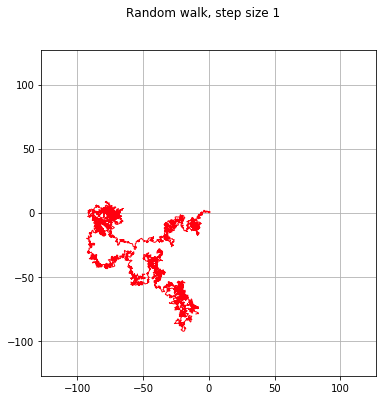

Final radial distance from origin is 79.63


In [134]:
"""A 2D Random Walk -- start at some initial position in x and y, pick a random theta wrt the horizontal, 
   and take a step in that direction."""

Nsteps = 5000

xvalues = []
yvalues = []
sum_of_R = 0

x=0.
y=0.
xvalues.append(x)
yvalues.append(y)

theta = 2.*np.pi*np.random.random(Nsteps)
for i in range(1, Nsteps):
    x += np.cos(theta[i])
    y += np.sin(theta[i])
    xvalues.append(x)
    yvalues.append(y)
    R=np.sqrt(x*x+y*y)


fig1=plt.figure(1,[6,6])
ax=fig1.gca()
ax.grid(True)
ysize=xsize=1.8*np.sqrt(Nsteps)
ax.set_ylim([-ysize, ysize])
ax.set_xlim([-xsize, xsize])
fig1.suptitle('Random walk, step size 1')
cmap=plt.cm.gist_rainbow
plt.plot(xvalues, yvalues,'-', lw=1, color=cmap(5))
plt.show()
print("Final radial distance from origin is %.2f" % R)



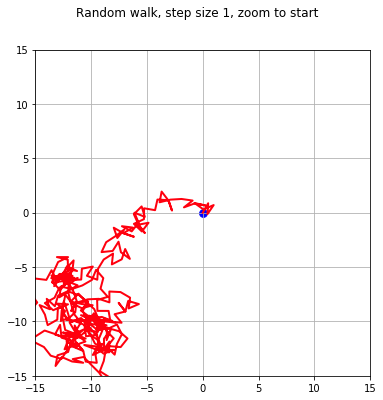

In [136]:
# zoom in around the starting point
fig1=plt.figure(1,[6,6])
ax=fig1.gca()
ax.grid(True)
ysize=xsize=15.
ax.set_ylim([-ysize, ysize])
ax.set_xlim([-xsize, xsize])
fig1.suptitle('Random walk, step size 1, zoom to start')
cmap=plt.cm.gist_rainbow
plt.plot(xvalues, yvalues,'-', lw=2, color=cmap(5))
plt.scatter(0., 0., 60, 'b')
plt.show()

Try many instances for a given $Nsteps$, then vary $Nsteps$. See what happens when $Nsteps$ is large. (What do you see in these :-) )? Also, what do you think the average total displacement should be as a function of $Nsteps$?

Note that there are different approaches. For example we could have thrown two randoms for each step (one for x and one for y). How might that be different (aside from needing 2x the random numbers)?

Many interesting applications, including diffusion and drift problems (can include energy loss and a variety of stochastic processes). We can also start to model ensembles of particles and their statistical properties.

## Metropolis Algorithm and an application: Ising model of magnetization

See Chapter 17.

We combine random walks and the accept/reject method to study thermodynamic properties of the 1-dim Ising model:

  - $N$ magnetic dipoles (atoms each with an unpaired electron) stuck on the links of a linear chain (a 1-dim lattice). 
  - The dipole at site $i$ has spin $s_{i}$, which is either up or down, the direction is defined by an external $B$ field. The spin can flip, but the atom doesn't move.

<img src="Figures/Figure_17.1.png" width="40%">

There are two interactions each dipole feels:
  - the dipole interaction with the external field
  - spin-spin interactions, which we take to be nearest-neighbor only. See section 17.4.3 for what happens in 2-d and with next-to-nearest neighbor interactions.
  
(Recall, an electron’s spin and magnetic moment are
proportional to each other, so a magnetic *dipole-dipole*
interaction is equivalent to a *spin-spin* interaction.) 

The energy for each site is therefore
$$V_{i} = - J\textbf{s}_{i}\cdot\textbf{s}_{i+1} - g \mu_B
\textbf{s}_{i}\cdot \textbf{B}$$

$J$ is the *exchange energy* and is a measure
of the strength of the spin-spin interaction relative to $g\mu_B$. It can be positive or negative.

The *state* of the system, $\alpha$, is stored in an array of dimension $N$, and the value in each array element corresponds to spin up (1) or spin down (-1). You can see that there are many possible states, and we are going to watch the system evolve.


If you are concerned about the boundaries, you can impose periodic boundary conditions: the first and last element of the array are nearest neighbors.

The energy of state $\alpha_k$ is the expectation value summed over the system:

$$E_{\alpha_k} = \Big\langle \alpha_k \Big|\sum_{i}V_{i}
\Big| \alpha_k \Big\rangle = -J \sum_{i=1}^{N-1} s_{i}s_{i+1} - B
\mu_b\sum_{i=1}^{N} s_{i}$$


**Things become interesting: the temperature is not zero!**

   - If $J>0$, the lowest energy state will tend to have neighboring spins aligned. If the temperature is low enough, the ground state will be a *ferromagnet* with all the spins aligned. Yet if $J<0$, the lowest energy state will tend to have neighbors with opposite spins. If the temperature is low enough, the ground state will be an *antiferromagnet* with alternating spins.
   - Fluctuations are allowed.

-----------
-----------


The **Metropolis algorithm** produces a sequence of states (called a Markov chain) that
simulate the fluctuations that occur during thermal equilibrium. 

    - The algorithm randomly changes individual spins such that, on the average, the probability of a configuration occurring follows a Boltzmann distribution. So this is where accept/reject comes in.

#### Game plan

   - Start at some specified temperature and an initial spin configuration, and apply the algorithm until a thermal equilibrium is reached (equilibration at a stable energy).

   - Continued application of the algorithm generates the statistical fluctuations about equilibrium from which we deduce the thermodynamic quantities such as the magnetization $M(T)$. 
   - Then the temperature is changed, and the whole process is repeated in order to deduce the $T$ dependence of the thermodynamic quantities.


#### Recipe

1.  Start with an arbitrary spin configuration $\alpha_{k}=\{s_1,
    s_2, \ldots, s_N\}$.

2.  Generate a trial new configuration $\alpha_\text{tr}$: pick a particle $i$ randomly and flip its spin. This is done by multiplying its value by -1 (see why?).

3.  Calculate the energy $E_{\alpha_{\text{trial}}}$ of the
    trial configuration.

4.  If $E_{\alpha_{\text{trial}}} \leq E_{\alpha_{k}}$, accept the trial by
    setting $\alpha_{k+1} = \alpha_{\text{trial}}$.

5.  If $E_{\alpha_{\text{trial}}} > E_{\alpha_{k}}$, DON'T JUST REJECT IT: accept with relative
    probability $ {\cal R} = \frac{\exp(-E_{\alpha_{\text{trial}}}/k_B T)}{\exp(-E_{\alpha_{k}}/k_B T)} = \exp(-\Delta E/k_B T)$, with $\Delta E = E_{\alpha_{\text{trial}}} - E_{\alpha_{k}}$:

    -   Choose a uniform random number $0 \leq r_i \leq
           1$

    -   Set $\alpha_{k+1} = \begin{cases}
        \alpha_{\text{trial}}, & \mbox{if} \ \  {\cal R} \geq r_i  \ \
        \mbox{(accept)},\\
        \alpha_{k}, & \mbox{if}\ \  {\cal R} < r_i \ \
        \mbox{(reject)}.
        \end{cases}$

Thus, we generate random spin configurations
$\alpha_{j}$ with probability 
$$
 {\cal P}(E_{\alpha_{j}},T) \propto e^{-
E_{\alpha_j}/k_BT}$$ 

Note that if $\mathcal{R}>1$, then the step is accepted immediately, and if $1 > \mathcal{R} \geq r_i$ the step is still accepted.  Effectively, the condition for acceptance is just $\mathcal{R}\geq r_i$.

The following code is based on the listing in the textbook, with a few modifications. You'll get to play with this on problem set 4.



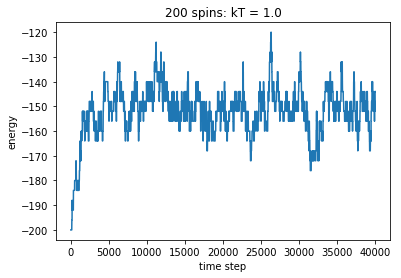

In [140]:
# Ising model implementation with Metropolis algorithm
# Based on IsingViz.py from Landau, et al.

N     = 200                 # number of spin sites                                     
num_steps = 200*N           # number of iterations
B     = 0.0                # magnetic field                               
mu    = .33                # g mu (not needed if B=0)
J     = 1.                 # exchange energy                              
k     = 1.                 # Boltzmann constant
T     = 1.                # temperature                                 
state = np.zeros([num_steps,N])        # spin states: up(1), down (-1)
np.random.seed() 
        
def energy(S):                                  
    FirstTerm = 0.
    SecondTerm = 0.                                          
    for i in range(-1,N-1):         # by starting with index -1, we can implement periodic boundary conditions
        FirstTerm += -J * S[i]*S[i+1]
    for i in range(0,N):   
        SecondTerm += -mu*S[i]*B
    return (FirstTerm + SecondTerm); 

for i in range(0 ,N):  
    state[0,i] = -1.          # Initial spins all down (cold start)  

ES = energy(state[0,:])
    
energy_values = []
step_index_values = []
for istep in range(1,num_steps):
    test_state = list(state[istep-1,:])
    random_site = int(N*np.random.random())
    test_state[random_site] *= -1.   # Trial step: flip spin at one random site
#    print(test_state)
    ET = energy(test_state)
    R = np.exp((ES-ET)/(k*T))           # Boltzmann test
#    print(ET, ES, R)
    state[istep,:]=state[istep-1,:]  # advance the previous state forward, unless....
    if R > np.random.random():
        state[istep,:] = test_state
        ES = ET
    # else stay as is
    
    energy_values.append(ES)
    step_index_values.append(istep)
# The following is useful output for purposes of debugging, but print statements are slow.
    row = ''
    for site in state[istep,:]:
        if site==1.0:
            row += 'X'
        else:
            # fancy codes for red O's (thanks, J. Nielsen). You could also make a scatter plot with matplotlib.
            row += '\x1b[31mO\x1b[0m'
#    print(row)
    
plt.rcParams["figure.figsize"] = [6,4]
plt.plot(step_index_values, energy_values)
plt.xlabel('time step')
plt.ylabel('energy')
plt.title('%d spins: kT = %.1f' % (N, k*T))
plt.show()

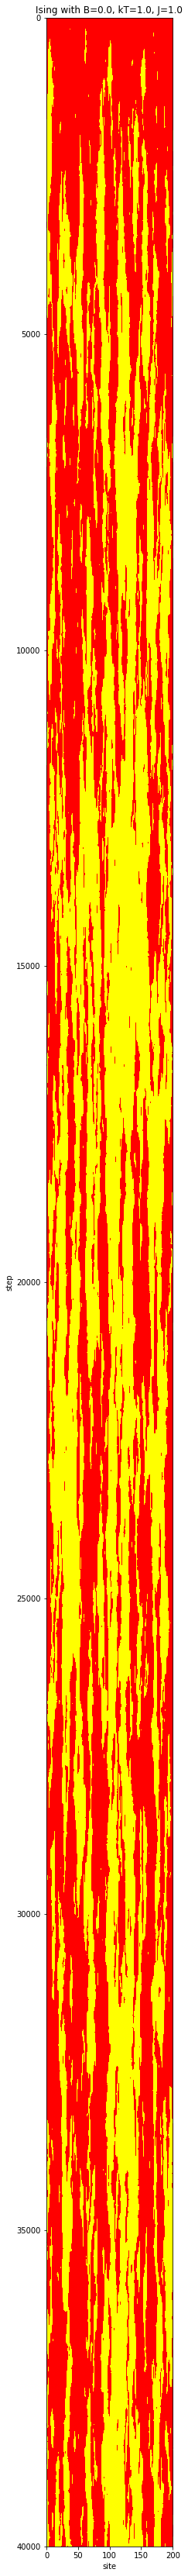

In [141]:
img = np.zeros([num_steps,N]).astype('int')
for i in range (0,num_steps):
    img[i,:]=state[i,:]
plt.rcParams["figure.figsize"] = [10,60]
plt.title('Ising with B='+str(B)+', kT='+str(k*T)+', J='+str(J))
plt.xlabel('site')
plt.ylabel('step')
plt.imshow(img, cmap=plt.cm.autumn, aspect=0.1)
plt.rcParams["figure.figsize"] = [6,6]



We see the development of magnetic domains, regions with spins pointed in the same direction, even at zero external magnetic field, but this depends very much on the parameters. See what happens with temperature, for example.

Your book recommends letting the system run for at least 10 times the number of members of the ensemble before "measuring" equilibrium thermal quantities. See section 17.4.2.


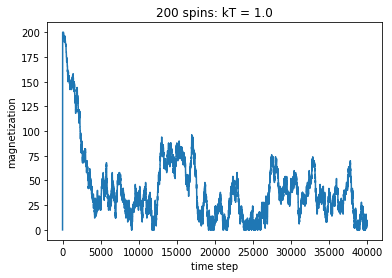

Magnetization averged over the second half of the run:  29.0067


In [142]:
# let's look at the magnetization
mags = np.zeros(num_steps).astype('float')
for i in range (1,num_steps):
    mags[i]=abs(np.sum(state[i,:]))
plt.rcParams["figure.figsize"] = [6,4]
plt.plot(step_index_values, mags[0:-1])
plt.xlabel('time step')
plt.ylabel('magnetization')
plt.title('%d spins: kT = %.1f' % (N, k*T))
plt.show()
magav=np.average(mags[int(num_steps/2):num_steps])
print("Magnetization averged over the second half of the run: ",magav)

Let's redo this: make the ising state calculator a function, then let's plot magnetization vs temperature

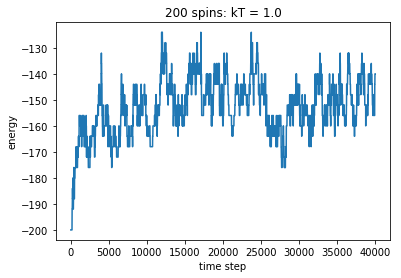

In [145]:
def energy(S,J,mu,B):                                  
    FirstTerm = 0.
    SecondTerm = 0.                                          
    for i in range(-1,len(S)-1):         # by starting with index -1, we can implement periodic boundary conditions
        FirstTerm += -J*S[i]*S[i+1]
    for i in range(0,N):   
        SecondTerm += -mu*S[i]*B
    return (FirstTerm + SecondTerm); 

def ising(state0,num_steps,J, mu, B, kT):
    ES = energy(state0,J,mu,B)
    energy_values = []
    energy_values.append(ES)
    state = np.zeros([num_steps,N])        # spin states: up(1), down (-1)
    state[0,:]=state0
    for istep in range(1,num_steps):
        test_state = list(state[istep-1,:])
        random_site = int(N*np.random.random())
        test_state[random_site] *= -1.   # Trial step: flip spin at one random site
#        print(test_state)
        ET = energy(test_state,J,mu,B)
        R = np.exp((ES-ET)/(kT))           # Boltzmann test
#        print(ET, ES, R)
        if R > np.random.random():
            state[istep,:] = test_state      # replace the state, or
            ES = ET
        else:
            state[istep,:]=state[istep-1,:]  # advance the previous state forward
        energy_values.append(ES)
# The following is useful output for purposes of debugging, but print statements are slow.
        row = ''
        for site in state[istep,:]:
            if site==1.0:
                row += 'X'
            else:
                # fancy codes for red O's (thanks, J. Nielsen). You could also make a scatter plot with matplotlib.
                row += '\x1b[31mO\x1b[0m'
#            print(row)
    
    return state, energy_values;

# first reproduce the older code result
N     = 200                 # number of spin sites                                     
num_steps = 200*N           # number of iterations
B     = 0.0                # magnetic field                               
mu    = .33                # g mu (not needed if B=0)
J     = 1.                 # exchange energy                              
k     = 1.                 # Boltzmann constant
T     = 1.                 # Temperature
np.random.seed() 
state0=np.empty(N) ; state0.fill(-1.)
kT=k*T
state, energy_values=ising(state0,num_steps,J, mu, B, kT)
istep = np.zeros(num_steps)        
for i, item in enumerate(energy_values):
    istep[i]=i
plt.rcParams["figure.figsize"] = [6,4]
plt.plot(istep, energy_values)
plt.xlabel('time step')
plt.ylabel('energy')
plt.title('%d spins: kT = %.1f' % (N, k*T))
plt.show()

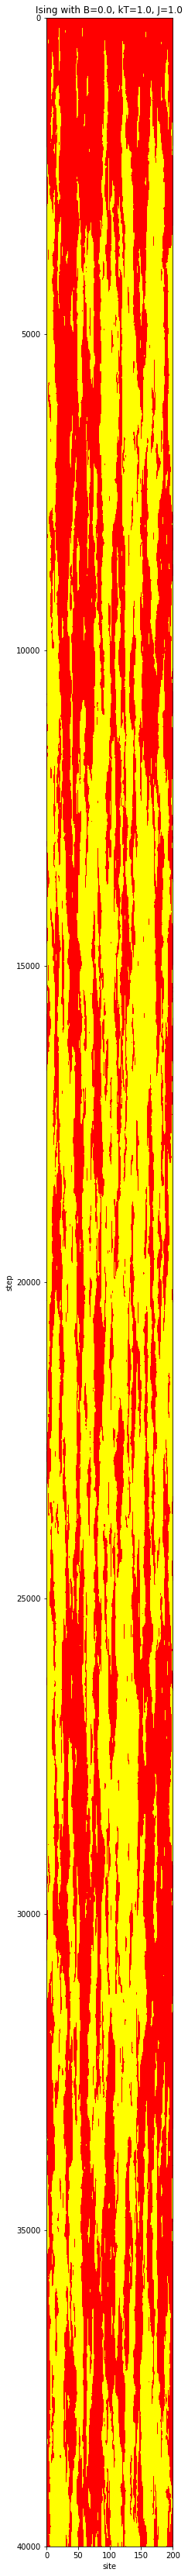

In [146]:
img = np.zeros([num_steps,N]).astype('int')
for i in range (0,num_steps):
    img[i,:]=state[i,:]
plt.rcParams["figure.figsize"] = [10,60]
plt.title('Ising with B='+str(B)+', kT='+str(k*T)+', J='+str(J))
plt.xlabel('site')
plt.ylabel('step')
plt.imshow(img, cmap=plt.cm.autumn, aspect=0.1)
plt.rcParams["figure.figsize"] = [6,6]




doing kT= 0.10 which is 1 out of 20
Magnetization averged over the second half of the run:  1.0
doing kT= 0.30 which is 2 out of 20
Magnetization averged over the second half of the run:  1.0
doing kT= 0.50 which is 3 out of 20
Magnetization averged over the second half of the run:  0.985050625
doing kT= 0.70 which is 4 out of 20
Magnetization averged over the second half of the run:  0.7793209375000001
doing kT= 0.90 which is 5 out of 20
Magnetization averged over the second half of the run:  0.2719284375
doing kT= 1.10 which is 6 out of 20
Magnetization averged over the second half of the run:  0.0623821875
doing kT= 1.30 which is 7 out of 20
Magnetization averged over the second half of the run:  0.0677678125
doing kT= 1.50 which is 8 out of 20
Magnetization averged over the second half of the run:  0.0638634375
doing kT= 1.70 which is 9 out of 20
Magnetization averged over the second half of the run:  0.049940937500000004
doing kT= 1.90 which is 10 out of 20
Magnetization averged o

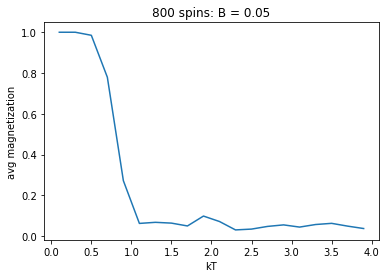

In [148]:
"""" now let's try a range of temperatures. 
To help with equilibration times, we'll let the end state for the last temp be the 
starting state for the next. It's worth trying the study both ways to see if there are significant differences."""
N     = 800                 # number of spin sites                                   
num_steps = 20*N           # number of iterations
B     = 0.05                # magnetic field                               
mu    = .33                # g mu (not needed if B=0)
J     = 1.                 # exchange energy                              
kTs=np.arange(0.1,4.,.2)
np.random.seed() 
state0=np.empty(N) ; state0.fill(-1.)
mags = np.zeros(num_steps).astype('float')
magav = np.zeros(len(kTs)).astype('float')
for i in range (0,len(kTs)):
    print('doing kT= %.2f which is %d out of %d' % (kTs[i],i+1,len(kTs)))
    state, energy_values=ising(state0,num_steps,J, mu, B, kTs[i])
    for j in range (1,num_steps):
        mags[j]=abs(np.sum(state[j,:]))
    magav[i]=np.average(mags[int(num_steps/2):num_steps])/N
    print("Magnetization averged over the second half of the run: ",magav[i])
    state0=state[(num_steps-1),:] # same the final state as the start of the next run

fig1=plt.figure(1,[6,4])
plt.plot(kTs, magav)
plt.xlabel('kT')
plt.ylabel('avg magnetization')
plt.title('%d spins: B = %.2f' % (N, B))
fig1.savefig('Ising800-lecture-a.pdf') # recall, here's how you save plots (could do png, just by changing the filename extension)
plt.show()

A promising result, but notice how long it would take to do this calculation for a good sample of spins, say $N=2000$. How can we make this run much faster? This is something for you to do on Problem Set 4. Once you make the algorithm more efficient, you can start exploring different ranges of parameters. Doing a similar calculation in two dimensions, and looking at thermodynamic quantities, would be an interesting class project.